In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [58]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_test = torch.Tensor( testset.data ) / 255.0# - 0.5
y_test = torch.Tensor( testset.targets ).long()
X_train = torch.Tensor( trainset.data ) / 255.0# - 0.5
y_train = torch.Tensor( trainset.targets ).long()

# train_dataset = TensorDataset(X_train, y_train)

train_data = DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True)
train_data_iter = iter(train_data)

test_data = DataLoader(testset, batch_size=256, shuffle=True, drop_last=True)
test_data_iter = iter(test_data)

# Noise scheduling-- how fast do we want to add noise?

We want to arrive at an isotropic Gaussian distribution: one with $0$ mean and equal covariances.

In [40]:
def linear_schedule(timesteps, start=1e-4, end=.02):
    betas = torch.linspace(start, end, timesteps)
    return betas

def cosine_schedule(timesteps, s=0.008):
    def f(t):
        return torch.cos((t / timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
    x = torch.linspace(0, timesteps, timesteps + 1)
    alphas_cumprod = f(x) / f(torch.tensor([0]))
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, 0.0001, 0.999)
    return betas

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    # print()
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
beta = cosine_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alpha = 1.0 - beta
alphas_cumprod = torch.cumprod(alpha, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alpha)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = beta * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


/tmp/ipykernel_8772/548532625.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


tensor([0])
torch.Size([256, 28, 28])
tensor([30])
torch.Size([256, 28, 28])
tensor([60])
torch.Size([256, 28, 28])
tensor([90])
torch.Size([256, 28, 28])
tensor([120])
torch.Size([256, 28, 28])
tensor([150])
torch.Size([256, 28, 28])
tensor([180])
torch.Size([256, 28, 28])
tensor([210])
torch.Size([256, 28, 28])
tensor([240])
torch.Size([256, 28, 28])
tensor([270])
torch.Size([256, 28, 28])


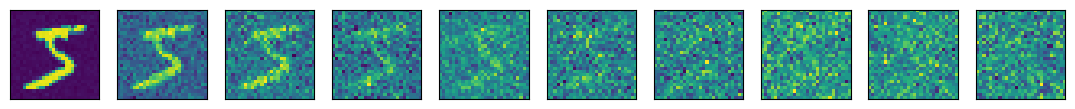

In [47]:
image = X_train[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    print(t)
    img, noise = forward_diffusion(image, t)
    print(img.shape)
    # plt.imshow(X_train[0], cmap="Greys")
    plt.imshow(img[0].detach().numpy())
    plt.xticks([])
    plt.yticks([])

In [59]:
class Diffusion():
    def __init__(self, T: int, model : nn.Module, optimizer, device='cpu', noise_model=''):
        assert device in {'cpu', 'gpu'}, ValueError

        self.T = T
        self.noise_model = model
        self.optimizer = optimizer
        self.device = device

        if noise_model == 'cosine':
            self.beta = cosine_schedule(timesteps=T)
        else: self.beta = linear_schedule(timesteps=T)

        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, axis=0)

        self.loss_function = torch.nn.MSELoss()

    def training(self, batch_size=256):
        X_batch, _ = next(train_data_iter)
        X_0 = X_batch.to(self.device)
        
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device)
        epsilon = torch.randn_like(X_0)

        alpha_bar_t = self.alpha_bar[t-1][:, None, None, None]
        epsilon_hat = self.noise_model(torch.sqrt(alpha_bar_t) * X_0 + torch.sqrt(1 - alpha_bar_t) * epsilon, t)

        loss = self.loss_function(epsilon, epsilon_hat)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    @torch.no_grad()
    def testing(self, batch_size=256):
        X_batch, _ = next(test_data_iter)
        X_0 = X_batch.to(self.device)
        
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device)
        epsilon = torch.randn_like(X_0)

        alpha_bar_t = self.alpha_bar[t-1][:, None, None, None]
        epsilon_hat = self.noise_model(torch.sqrt(alpha_bar_t) * X_0 + torch.sqrt(1 - alpha_bar_t) * epsilon, t)

        loss = self.loss_function(epsilon, epsilon_hat)

        return loss.item()

    @torch.no_grad()
    def sampling(self, batch_size=256, image_channels=1, img_size=(28, 28)):
        assert len(img_size) == 2, ValueError

        X = torch.randn((batch_size, image_channels, *img_size), device=self.device)

        for t in range(self.T, 0, -1):
            z = torch.randn_like(X) if t > 1 else torch.zeros_like(X)
            
            beta_t = self.beta[t-1][:, None, None, None]
            alpha_t = self.alpha[t-1][:, None, None, None]
            alpha_bar_t = self.alpha_bar[t-1][:, None, None, None]

            mu = 1/torch.sqrt(alpha_t) * (X - (1 - alpha_t)/(torch.sqrt(1 - alpha_bar_t)) * self.noise_model(X, t))
            sigma = torch.sqrt(beta_t)

            X = mu + sigma * z
            

In [60]:
d = Diffusion(T=T, model=None)

TypeError: __init__() missing 1 required positional argument: 'optimizer'